In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/CIS6200_Project/all_qa_df.pkl"

Mounted at /content/drive


## **General**

In [ ]:
def extract_expected_option(expected_answer, options):
    """
    Searches through the lines in the options block for a line whose answer
    value matches the expected answer. Handles both numeric (including negative
    numbers and percentages) and textual matching. Returns the matching option
    number as an integer.
    """
    # Remove "%" characters and extra whitespace for numeric comparison
    expected_clean = expected_answer.replace("%", "").strip()

    # Try to convert the cleaned expected answer to a float
    try:
        expected_val = float(expected_clean)
        is_numeric = True
    except ValueError:
        is_numeric = False
        expected_normalized = expected_answer.strip().lower()

    for line in options.split('\n'):
        line = line.strip()
        # Match "Option <number>: <value>" where <value> can be anything
        match = re.match(r"Option (\d+):\s*(.+)", line)
        if match:
            option_num = int(match.group(1))
            option_content = match.group(2).strip()

            if is_numeric:
                # Remove "%" from the option's content as well
                option_clean = option_content.replace("%", "").strip()
                try:
                    option_val = float(option_clean)
                    if option_val == expected_val:
                        return option_num
                except ValueError:
                    # If conversion fails, fall back to textual matching
                    pass

            # For non-numeric matching: perform a case-insensitive substring check
            if not is_numeric:
                if expected_normalized in option_content.lower():
                    return option_num
    return None


def process_all_files(directory):
    results = []

    for filename in os.listdir(directory):
        if filename.startswith("responses_") and (filename.endswith(".csv")):
            question_type = filename[len("responses_"):].split('.')[0]
            print("Processing type:", question_type)
            file_path = os.path.join(directory, filename)
            results.append(process_file(file_path, question_type))

    return pd.DataFrame(results, columns=["question_type", "correct", "incorrect"])

def plot_accuracy_by_question_type(results_df, name):
    """
    Given a DataFrame with columns 'question_type', 'correct', and 'incorrect',
    computes total number of responses and percentage correct/incorrect,
    prints a summary sorted by correct percentage, and plots a stacked bar chart.

    Parameters:
      results_df: pandas DataFrame that includes at least the columns:
                  'question_type', 'correct', and 'incorrect'.
      name:       A string that will be used as part of the plot title.
    """
    # Make a copy to avoid modifying the original DataFrame.
    results_df = results_df.copy()
    results_df['total'] = results_df['correct'] + results_df['incorrect']

    # Compute percentage values.
    results_df['correct_pct'] = (results_df['correct'] / results_df['total']) * 100
    results_df['incorrect_pct'] = (results_df['incorrect'] / results_df['total']) * 100

    # Sort by correct percentage descending.
    sorted_df = results_df.sort_values(by='correct_pct', ascending=False)

    # Prepare the data for plotting (set index to question_type).
    percent_df_sorted = sorted_df[['question_type', 'correct_pct', 'incorrect_pct']].set_index('question_type')

    # Create a stacked bar plot.
    ax = percent_df_sorted.plot(kind='bar', stacked=True, color=['green', 'red'], figsize=(12,6))

    # Combine the name and additional text to form one title string.
    ax.set_title(f"{name} Correct vs Incorrect by Question Type")
    ax.set_xlabel('Question Type')
    ax.set_ylabel('Percentage (%)')
    plt.xticks(rotation=90)
    plt.legend(['Correct (%)', 'Incorrect (%)'], loc='upper right')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

## **GPT**

In [ ]:
def extract_selected_option(response_text, options):
    """
    Extracts the answer part from the response (before the '|' delimiter)
    and returns an option number if the response explicitly contains 'Option X'
    or if it contains a numeric value that matches one of the options.
    """
    # Split the response at the pipe character and strip whitespace.
    # answer_part = response_text.split('|')[0].strip()
    answer_part = response_text.strip()

    # Check if the response explicitly mentions an option (e.g., "Option 1").
    match = re.search(r"Option (\d+)", answer_part, re.IGNORECASE)
    if match:
        return int(match.group(1))

    # Otherwise, extract a candidate numeric value from the answer.
    number_match = re.search(r"(\d+(?:\.\d+)?)", answer_part)
    if number_match:
        candidate_value = number_match.group(1)
        # Now, determine which option (by scanning the options list) contains that number.
        for line in options.split('\n'):
            if candidate_value in line:
                m = re.match(r"Option (\d+):", line.strip())
                if m:
                    return int(m.group(1))

    return None

def process_file(file_path, question_type):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        print("Should not happen")
        return (question_type, 0, 0)



    correct = 0
    incorrect = 0

    for _, row in df.iterrows():
        selected_option = None

        if 'response' in df.columns:
            if pd.notna(row['response']):
                selected_option = extract_selected_option(str(row['response']), str(row['options']))
        elif 'correct_response' in df.columns:
            if pd.notna(row['correct_response']):
                selected_option = extract_selected_option(str(row['correct_response']), str(row['options']))

        ### TODO: we should add one logic and variable to track when model does not the format
        if selected_option is None:
            print(row['question_id'], " has no matched option.")

        expected_option = extract_expected_option(str(row['expected_answer']), str(row['options']))

        if expected_option is None:
            print(row['question_id'], " has no matched expected answer.")

        if selected_option is not None and expected_option is not None:
            if selected_option == expected_option:
                correct += 1
            else:
                incorrect += 1

    return (question_type, correct, incorrect)

In [ ]:
gpt_3_5_df = process_all_files("/content/drive/MyDrive/CIS6200_Project/results_3_5")

In [ ]:
gpt_4_o_df = process_all_files("/content/drive/MyDrive/CIS6200_Project/results_4o")

### **Post-Processing**

In [ ]:
gpt_3_5_df.loc[gpt_3_5_df['question_type'] == 'prob_basic', 'correct'] += 4
gpt_3_5_df.loc[gpt_3_5_df['question_type'] == 'prob_basic', 'incorrect'] += 5
gpt_3_5_df.loc[gpt_3_5_df['question_type'] == 'trigger', 'incorrect'] += 2

In [ ]:
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'add_sub', 'correct'] += 6
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'bayes_rule', 'incorrect'] += 5
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'best_response', 'incorrect'] += 7
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'best_response', 'correct'] += 1
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'condorcet_criterion', 'correct'] += 1
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'dominant_strategies', 'correct'] += 1
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'dominated_strategies', 'correct'] += 6
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'dominated_strategies', 'incorrect'] += 2
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'feasibility', 'incorrect'] += 2
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'first_order_false_belief', 'correct'] += 3
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'pareto_sc', 'correct'] += 5
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'prob_basic', 'correct'] += 9
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'pure_nash', 'incorrect'] += 1
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'second_order_false_belief', 'correct'] += 7
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'subgame_nash', 'incorrect'] += 3
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'trigger', 'correct'] += 1
gpt_4_o_df.loc[gpt_4_o_df['question_type'] == 'trigger', 'incorrect'] += 1

### **Analysis**

In [ ]:
print(gpt_3_5_df)

                question_type  correct  incorrect
0                     add_sub       26         25
1          ambiguity_aversion        8          7
2               auctions_risk        9         42
3          backward_induction        5         46
4                  bayes_nash       10         41
5                  bayes_rule       14         37
6               best_response       10         41
7                 borda_count       18         33
8              budget_balance       29         22
9       categorical_syllogism       29         22
10           certainty_effect       13         38
11            complement_rule       43          8
12               completeness       46          5
13          completeness_risk       51          0
14       compute_expectations       13         38
15   compute_expected_utility       34         17
16      conditional_syllogism       10         41
17        condorcet_criterion       24         27
18        dominant_strategies       51          0


In [ ]:
print(gpt_4_o_df)

                question_type  correct  incorrect
0                     add_sub       46          5
1          ambiguity_aversion        5         10
2               auctions_risk        5         46
3          backward_induction       23         28
4                  bayes_nash       29         22
5                  bayes_rule       27         24
6               best_response       15         36
7                 borda_count       46          5
8              budget_balance       38         13
9       categorical_syllogism       46          5
10           certainty_effect       49          2
11            complement_rule       50          1
12               completeness       50          1
13          completeness_risk       51          0
14       compute_expectations       51          0
15   compute_expected_utility       51          0
16      conditional_syllogism       51          0
17        condorcet_criterion       33         18
18        dominant_strategies       51          0


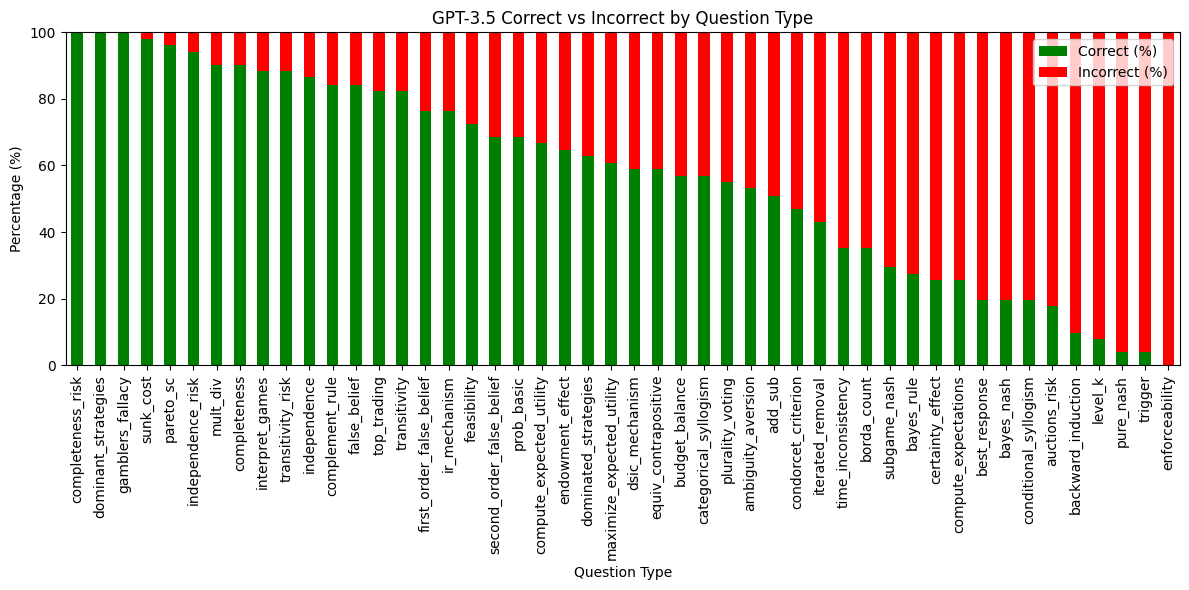

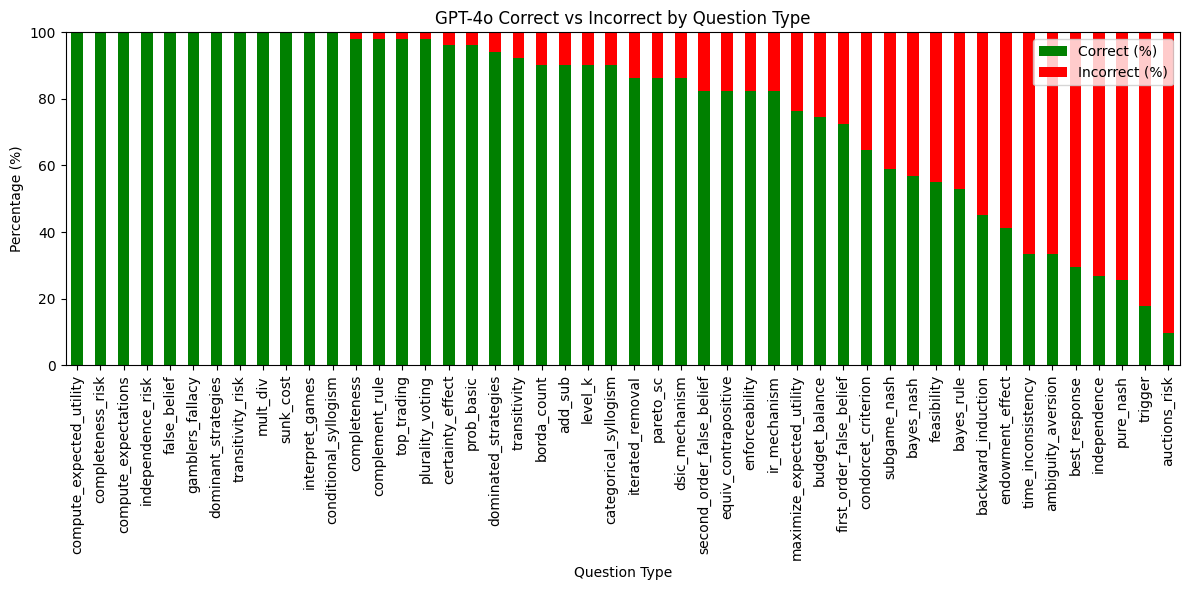

In [ ]:
plot_accuracy_by_question_type(gpt_3_5_df, "GPT-3.5")
plot_accuracy_by_question_type(gpt_4_o_df, "GPT-4o")

## **DeepSeek R1 7b (vLLM)**

In [ ]:
def extract_selected_option(response_text, options):
    """
    Extracts a single option number from the response_text.
    1) If the entire response is just a digit (e.g. "1"), map that directly to Option 1, etc.
    2) If it says "Option <n>", use that.
    3) If it’s exactly one letter A–D, map A→1, B→2, etc.
    4) Otherwise fall back to numeric matching inside the options block.
    Ambiguous or missing → return None.
    """
    text = response_text.strip()

    # --- NEW: direct numeric response ---
    if re.fullmatch(r"\d+", text):
        opt = int(text)
        # verify Option <opt> actually exists
        if re.search(rf"^Option\s+{opt}:", options, re.MULTILINE):
            return opt
        else:
            # numeric but out of range
            return None

    # 1) explicit "Option <n>"
    explicit = re.findall(r"Option\s+(\d+)", text, re.IGNORECASE)
    if len(explicit) > 1:
        return None
    if len(explicit) == 1:
        return int(explicit[0])

    # 2) single‑letter A–D
    letters = re.findall(r"\b([A-D])\b", text, re.IGNORECASE)
    if len(letters) == 1:
        opt = ord(letters[0].upper()) - ord('A') + 1
        if re.search(rf"^Option\s+{opt}:", options, re.MULTILINE):
            return opt
        return None

    # 3) numeric fallback via substring scan
    numbers = re.findall(r"(\d+(?:\.\d+)?)", text)
    if numbers:
        matched = set()
        for num in numbers:
            for line in options.split('\n'):
                if num in line:
                    m = re.match(r"Option\s+(\d+):", line.strip())
                    if m:
                        matched.add(int(m.group(1)))
        if len(matched) == 1:
            return matched.pop()

    return None

def process_file(file_path, question_type):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        print("Should not happen")
        return (question_type, 0, 0)

    correct = 0
    incorrect = 0
    exceed_context = 0

    for _, row in df.iterrows():
        selected_option = None

        # 1) If there's a non‐empty correct_response, use that…
        if 'correct_response' in df.columns \
           and pd.notna(row['correct_response']) \
           and str(row['correct_response']).strip():
            selected_text = str(row['correct_response']).strip()
        # 2) …otherwise, fall back to final_answer (if present)
        elif 'final_answer' in df.columns \
             and pd.notna(row['final_answer']) \
             and str(row['final_answer']).strip():
            selected_text = str(row['final_answer']).strip()
        else:
            selected_text = None

        if selected_text is None:
            exceed_context += 1
            continue

        # print(f"{row['question_id']}: selected_text: {selected_text}")

        selected_option = extract_selected_option(selected_text, str(row['options']))

        if selected_option is None:
            print(f"{row['question_id']} has no matched option.")

        expected_option = extract_expected_option(str(row['expected_answer']), str(row['options']))

        if expected_option is None:
            print(f"{row['question_id']} has no matched expected answer.")

        # Compare
        if selected_option is not None and expected_option is not None:
            if selected_option == expected_option:
                correct += 1
            else:
                incorrect += 1

    return (question_type, correct, incorrect, exceed_context)

def process_all_files(directory):
    results = []

    for filename in os.listdir(directory):
        if filename.startswith("responses_") and (filename.endswith(".csv")):
            question_type = filename[len("responses_"):].split('.')[0]
            print("Processing type:", question_type)
            file_path = os.path.join(directory, filename)
            results.append(process_file(file_path, question_type))

    return pd.DataFrame(results, columns=["question_type", "correct", "incorrect", "exceed_context"])

In [ ]:
deepseek_r1_7b_df = process_all_files("/content/drive/MyDrive/CIS6200_Project/results_ds_7b_v2")

Processing type: add_sub
1_0 has no matched option.
20_0 has no matched option.
21_0 has no matched option.
22_0 has no matched option.
26_0 has no matched option.
35_0 has no matched option.
36_0 has no matched option.
33_0 has no matched option.
37_0 has no matched option.
39_0 has no matched option.
34_0 has no matched option.
38_0 has no matched option.
46_0 has no matched option.
47_0 has no matched option.
Processing type: top_trading
Processing type: transitivity
2_0 has no matched option.
4_0 has no matched option.
6_0 has no matched option.
5_0 has no matched option.
9_0 has no matched option.
15_0 has no matched option.
19_0 has no matched option.
21_0 has no matched option.
27_0 has no matched option.
28_0 has no matched option.
26_0 has no matched option.
31_0 has no matched option.
30_0 has no matched option.
40_0 has no matched option.
41_0 has no matched option.
44_0 has no matched option.
43_0 has no matched option.
47_0 has no matched option.
48_0 has no matched option

In [ ]:
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'add_sub', 'correct'] += 13
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'add_sub', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'transitivity', 'correct'] += 15
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'transitivity', 'incorrect'] += 5
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'transivity_risk', 'exceed_context'] += 4
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'time_inconsistency', 'correct'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'time_inconsistency', 'exceed_context'] += 3
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'prob_basic', 'correct'] += 10
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'prob_basic', 'incorrect'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'ir_mechanism', 'correct'] += 19
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'ir_mechanism', 'incorrect'] += 6
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'plurality_voting', 'correct'] += 8
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'plurality_voting', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'gambler_fallacy', 'correct'] += 13
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'false_belief', 'correct'] += 2
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'false_belief', 'incorrect'] += 4
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'independence_risk', 'correct'] += 45
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'equiv_contrapositive', 'correct'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'equiv_contrapositive', 'incorrect'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'dsic_mechanism', 'correct'] += 3
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'endowment_effect', 'correct'] += 2
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'endowment_effect', 'incorrect'] += 6
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'subgame_nash', 'correct'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'subgame_nash', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'compute_expectations', 'correct'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'categorical_syllogism', 'correct'] += 2
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'conditional_syllogism', 'correct'] += 4
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'completeness_risk', 'correct'] += 43
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'complement_rule', 'correct'] += 2
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'trigger', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'enforceability', 'incorrect'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'budget_balance', 'correct'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'budget_balance', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'bayes_rule', 'exceed_context'] += 2
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'certainty_effect', 'exceed_context'] += 5
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'autions_risk', 'incorrect'] += 6
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'bayes_nash', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'iterated_removal', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'dominated_strategies', 'correct'] += 3
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'dominated_strategies', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'mult_div', 'correct'] += 6
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'completeness', 'correct'] += 21
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'borda_count', 'correct'] += 5
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'borda_count', 'incorrect'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'borda_count', 'exceed_context'] += 9
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'dominant_strategies', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'pure_nash', 'correct'] += 2
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'pure_nash', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'interpret_games', 'exceed_context'] += 2
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'best_response', 'incorrect'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'best_response', 'exceed_context'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'maximize_expected_utility', 'correct'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'maximize_expected_utility', 'exceed_context'] += 2
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'condorcet_criterion', 'correct'] += 2
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'condorcet_criterion', 'exceed_context'] += 4
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'sunk_cost', 'correct'] += 12
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'sunk_cost', 'incorrect'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'pareto_sc', 'correct'] += 8
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'independence', 'correct'] += 1
deepseek_r1_7b_df.loc[deepseek_r1_7b_df['question_type'] == 'independence', 'incorrect'] += 1

In [ ]:
print(deepseek_r1_7b_df)

                question_type  correct  incorrect  exceed_context
0                     add_sub       41          0               9
1                 top_trading       34          6              10
2                transitivity       44          5               1
3           transitivity_risk       29          0              17
4          time_inconsistency        6          1              45
5   second_order_false_belief       34          2               3
6                  prob_basic       48          1               1
7                     level_k        7          0              43
8                ir_mechanism       36         13               1
9    first_order_false_belief       28          2               2
10           plurality_voting       33          5              12
11           gamblers_fallacy       33          0               4
12               false_belief       31         16               3
13          independence_risk       49          0               2
14       e

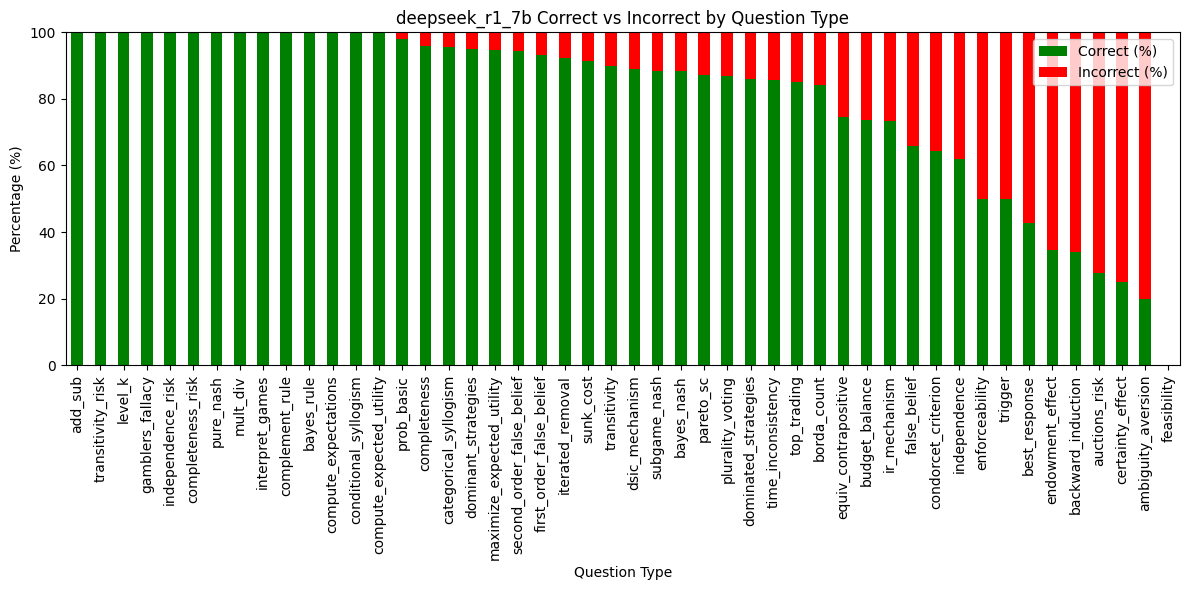

In [ ]:
plot_accuracy_by_question_type(deepseek_r1_7b_df, "deepseek_r1_7b")

## **DeepSeek R1 7b (Nvidia API)**

In [ ]:
def extract_selected_option(response_text, options):
    """
    Extracts a single option number from the response_text.
    1) If the entire response is just a digit (e.g. "1"), map that directly to Option 1, etc.
    2) If it says "Option <n>", use that.
    3) If it’s exactly one letter A–D, map A→1, B→2, etc.
    4) Otherwise fall back to numeric matching inside the options block.
    Ambiguous or missing → return None.
    """
    text = response_text.strip()

    # --- NEW: direct numeric response ---
    if re.fullmatch(r"\d+", text):
        opt = int(text)
        # verify Option <opt> actually exists
        if re.search(rf"^Option\s+{opt}:", options, re.MULTILINE):
            return opt
        else:
            # numeric but out of range
            return None

    # 1) explicit "Option <n>"
    explicit = re.findall(r"Option\s+(\d+)", text, re.IGNORECASE)
    if len(explicit) > 1:
        return None
    if len(explicit) == 1:
        return int(explicit[0])

    # 2) single‑letter A–D
    letters = re.findall(r"\b([A-D])\b", text, re.IGNORECASE)
    if len(letters) == 1:
        opt = ord(letters[0].upper()) - ord('A') + 1
        if re.search(rf"^Option\s+{opt}:", options, re.MULTILINE):
            return opt
        return None

    # 3) numeric fallback via substring scan
    numbers = re.findall(r"(\d+(?:\.\d+)?)", text)
    if numbers:
        matched = set()
        for num in numbers:
            for line in options.split('\n'):
                if num in line:
                    m = re.match(r"Option\s+(\d+):", line.strip())
                    if m:
                        matched.add(int(m.group(1)))
        if len(matched) == 1:
            return matched.pop()

    return None

def process_file(file_path, question_type):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        print("Should not happen")
        return (question_type, 0, 0)

    correct = 0
    incorrect = 0
    exceed_context = 0

    for _, row in df.iterrows():
        selected_option = None

        # 1) If there's a non‐empty correct_response, use that…
        if 'correct_response' in df.columns \
           and pd.notna(row['correct_response']) \
           and str(row['correct_response']).strip():
            selected_text = str(row['correct_response']).strip()
        # 2) …otherwise, fall back to final_answer (if present)
        elif 'final_answer' in df.columns \
             and pd.notna(row['final_answer']) \
             and str(row['final_answer']).strip():
            selected_text = str(row['final_answer']).strip()
        else:
            selected_text = None

        if selected_text is None:
            exceed_context += 1
            continue

        # print(f"{row['question_id']}: selected_text: {selected_text}")

        selected_option = extract_selected_option(selected_text, str(row['options']))

        if selected_option is None:
            print(f"{row['question_id']} has no matched option.")

        expected_option = extract_expected_option(str(row['expected_answer']), str(row['options']))

        if expected_option is None:
            print(f"{row['question_id']} has no matched expected answer.")

        # Compare
        if selected_option is not None and expected_option is not None:
            if selected_option == expected_option:
                correct += 1
            else:
                incorrect += 1

    return (question_type, correct, incorrect, exceed_context)

def process_all_files(directory):
    results = []

    for filename in os.listdir(directory):
        if filename.startswith("responses_") and (filename.endswith(".csv")):
            question_type = filename[len("responses_"):].split('.')[0]
            print("Processing type:", question_type)
            file_path = os.path.join(directory, filename)
            results.append(process_file(file_path, question_type))

    return pd.DataFrame(results, columns=["question_type", "correct", "incorrect", "exceed_context"])

In [ ]:
deepseek_r1_7b_nvidia_df = process_all_files("/content/drive/MyDrive/CIS6200_Project/results_ds_7b_nvidia")

Processing type: interpret_games
Processing type: condorcet_criterion
11_0 has no matched option.
16_0 has no matched option.
19_0 has no matched option.
33_0 has no matched option.
Processing type: conditional_syllogism
5_0 has no matched option.
26_0 has no matched option.
Processing type: mult_div
13_0 has no matched option.
15_0 has no matched option.
16_0 has no matched option.
25_0 has no matched option.
45_0 has no matched option.
Processing type: equiv_contrapositive
28_0 has no matched option.
Processing type: time_inconsistency
9_0 has no matched option.
12_0 has no matched option.
14_0 has no matched option.
15_0 has no matched option.
18_0 has no matched option.
26_0 has no matched option.
28_0 has no matched option.
30_0 has no matched option.
Processing type: bayes_rule
38_0 has no matched option.
Processing type: pure_nash
2_0 has no matched option.
4_0 has no matched option.
8_0 has no matched option.
12_0 has no matched option.
17_0 has no matched option.
20_0 has no m

In [ ]:
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'condorcet_criterion', 'incorrect'] += 4
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'conditional_syllogism', 'correct'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'mult_div', 'correct'] += 5
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'equiv_contrapositive', 'incorrect'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'time_inconsistency', 'correct'] += 7
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'time_inconsistency', 'incorrect'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'bayes_rule', 'incorrect'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'pure_nash', 'correct'] += 5
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'pure_nash', 'incorrect'] += 7
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'dominated_strategies', 'correct'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'dominated_strategies', 'incorrect'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'dsic_mechanism', 'correct'] += 5
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'pareto_sc', 'correct'] += 7
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'budget_balance', 'incorrect'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'iterated_removal', 'correct'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'iterated_removal', 'incorrect'] += 4
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'dominant_strategies', 'correct'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'bayes_nash', 'incorrect'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'independence_risk', 'correct'] += 11
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'sunk_cost', 'correct'] += 8
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'sunk_cost', 'incorrect'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'independence', 'incorrect'] += 3
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'false_belief', 'correct'] += 3
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'false_belief', 'incorrect'] += 9
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'completeness', 'correct'] += 39
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'completeness', 'incorrect'] += 3
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'complement_rule', 'correct'] += 3
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'compute_expectations', 'correct'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'feasibility', 'incorrect'] += 5
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'best_response', 'correct'] += 7
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'best_response', 'incorrect'] += 5
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'plurality_voting', 'correct'] += 7
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'plurality_voting', 'incorrect'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'add_sub', 'correct'] += 7
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'borda_count', 'correct'] += 9
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'borda_count', 'incorrect'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'endowment_effect', 'incorrect'] += 3
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'gamblers_fallacy', 'correct'] += 7
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'gamblers_fallacy', 'incorrect'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'maximize_expected_utility', 'correct'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'maximize_expected_utility', 'incorrect'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'completeness_risk', 'correct'] += 15
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'subgame_nash', 'correct'] += 5
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'subgame_nash', 'incorrect'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'level_k', 'incorrect'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'auctions_risk', 'correct'] += 4
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'auctions_risk', 'incorrect'] += 9
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'enforceability', 'incorrect'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'ir_mechanism', 'correct'] += 17
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'ir_mechanism', 'incorrect'] += 8
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'certainty_effect', 'incorrect'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'prob_basic', 'correct'] += 8
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'prob_basic', 'incorrect'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'categorical_syllogism', 'correct'] += 2
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'transitivity_risk', 'incorrect'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'trigger', 'correct'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'trigger', 'incorrect'] += 4
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'top_trading', 'correct'] += 1
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'transitivity', 'correct'] += 10
deepseek_r1_7b_nvidia_df.loc[deepseek_r1_7b_nvidia_df['question_type'] == 'transitivity', 'incorrect'] += 3

In [ ]:
print(deepseek_r1_7b_nvidia_df)

                question_type  correct  incorrect  exceed_context
0             interpret_games       43          6               0
1         condorcet_criterion       31         19               0
2       conditional_syllogism       49          1               0
3                    mult_div       44          1               0
4        equiv_contrapositive       36         12               0
5          time_inconsistency       28         17               0
6                  bayes_rule       40          8               0
7                   pure_nash       25         22               0
8        dominated_strategies       42          8               0
9              dsic_mechanism       44          5               0
10                  pareto_sc       42          6               0
11         backward_induction       18         32               0
12             budget_balance       30         20               0
13   compute_expected_utility       50          0               0
14        

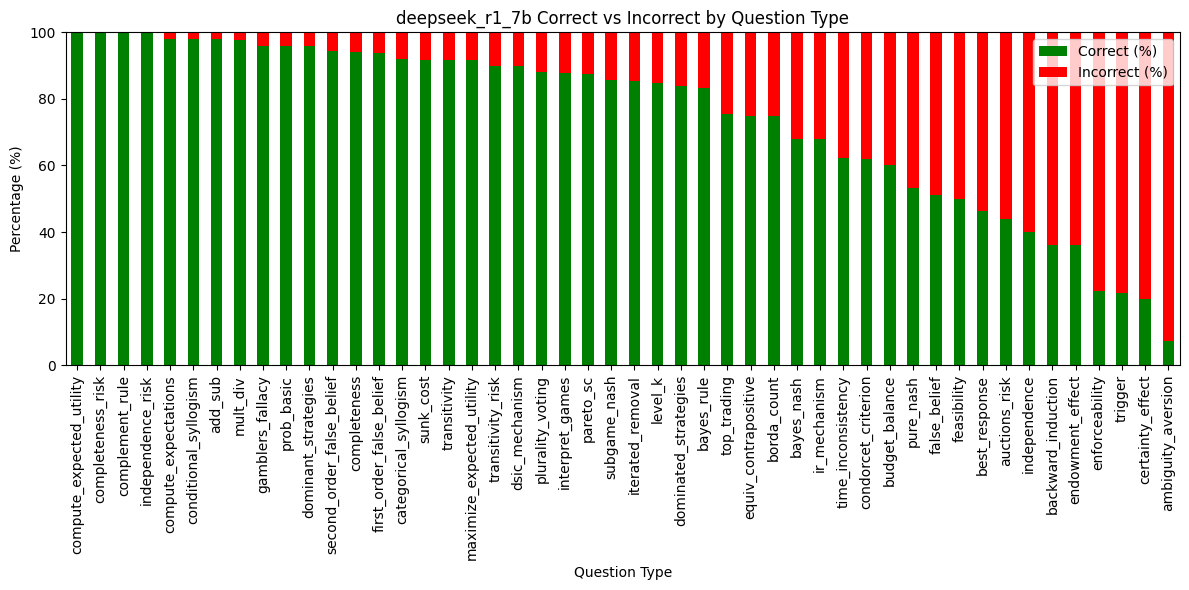

In [ ]:
plot_accuracy_by_question_type(deepseek_r1_7b_nvidia_df, "deepseek_r1_7b")

## **DeepSeek R1 7b (Selected Questions)**

In [ ]:
def extract_selected_option(response_text, options):
    """
    Extracts a single option number from the response_text.
    1) If the entire response is just a digit (e.g. "1"), map that directly to Option 1, etc.
    2) If it says "Option <n>", use that.
    3) If it’s exactly one letter A–D, map A→1, B→2, etc.
    4) Otherwise fall back to numeric matching inside the options block.
    Ambiguous or missing → return None.
    """
    text = response_text.strip()

    # --- NEW: direct numeric response ---
    if re.fullmatch(r"\d+", text):
        opt = int(text)
        # verify Option <opt> actually exists
        if re.search(rf"^Option\s+{opt}:", options, re.MULTILINE):
            return opt
        else:
            # numeric but out of range
            return None

    # 1) explicit "Option <n>"
    explicit = re.findall(r"Option\s+(\d+)", text, re.IGNORECASE)
    if len(explicit) > 1:
        return None
    if len(explicit) == 1:
        return int(explicit[0])

    # 2) single‑letter A–D
    letters = re.findall(r"\b([A-D])\b", text, re.IGNORECASE)
    if len(letters) == 1:
        opt = ord(letters[0].upper()) - ord('A') + 1
        if re.search(rf"^Option\s+{opt}:", options, re.MULTILINE):
            return opt
        return None

    # 3) numeric fallback via substring scan
    numbers = re.findall(r"(\d+(?:\.\d+)?)", text)
    if numbers:
        matched = set()
        for num in numbers:
            for line in options.split('\n'):
                if num in line:
                    m = re.match(r"Option\s+(\d+):", line.strip())
                    if m:
                        matched.add(int(m.group(1)))
        if len(matched) == 1:
            return matched.pop()

    return None

def process_file(file_path, question_type):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        print("Should not happen")
        return (question_type, 0, 0)

    correct = 0
    incorrect = 0
    exceed_context = 0

    for _, row in df.iterrows():
        selected_option = None

        # 1) If there's a non‐empty correct_response, use that…
        if 'correct_response' in df.columns \
           and pd.notna(row['correct_response']) \
           and str(row['correct_response']).strip():
            selected_text = str(row['correct_response']).strip()
        # 2) …otherwise, fall back to final_answer (if present)
        elif 'final_answer' in df.columns \
             and pd.notna(row['final_answer']) \
             and str(row['final_answer']).strip():
            selected_text = str(row['final_answer']).strip()
        else:
            selected_text = None

        if selected_text is None:
            exceed_context += 1
            continue

        # print(f"{row['question_id']}: selected_text: {selected_text}")

        selected_option = extract_selected_option(selected_text, str(row['options']))

        if selected_option is None:
            print(f"{row['question_id']} has no matched option.")

        expected_option = extract_expected_option(str(row['expected_answer']), str(row['options']))

        if expected_option is None:
            print(f"{row['question_id']} has no matched expected answer.")

        # Compare
        if selected_option is not None and expected_option is not None:
            if selected_option == expected_option:
                correct += 1
            else:
                incorrect += 1

    return (question_type, correct, incorrect, exceed_context)

def process_all_files(directory):
    results = []

    for filename in os.listdir(directory):
        if (filename.endswith("responses.csv")):
            question_type = filename[:-len("_responses.csv")]
            print("Processing type:", question_type)
            file_path = os.path.join(directory, filename)
            results.append(process_file(file_path, question_type))

    return pd.DataFrame(results, columns=["question_type", "correct", "incorrect", "exceed_context"])

In [ ]:
deepseek_r1_7b_finetuned_df = process_all_files("/content/drive/MyDrive/CIS6200_Project/results_ds_7b_tuned_0421")

Processing type: maximize_expected_utility
39_0 has no matched option.
Processing type: borda_count
27_0 has no matched option.
15_0 has no matched option.
23_0 has no matched option.
8_0 has no matched option.
28_0 has no matched option.
24_0 has no matched option.
Processing type: subgame_nash
272_0 has no matched option.
15_0 has no matched option.
57_0 has no matched option.
124_0 has no matched option.
Processing type: mult_div
385_0 has no matched option.
137_0 has no matched option.
332_0 has no matched option.
364_0 has no matched option.
265_0 has no matched option.
Processing type: second_order_false_belief
Processing type: bayes_nash
0_0 has no matched option.
1_0 has no matched option.
2_0 has no matched option.
3_0 has no matched option.
4_0 has no matched option.
5_0 has no matched option.
Processing type: auctions_risk
1_0 has no matched option.
4_0 has no matched option.
7_0 has no matched option.
3_0 has no matched option.
Processing type: trigger
12019_0 has no matche

In [ ]:
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'maximize_expected_utility', 'incorrect'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'borda_count', 'correct'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'borda_count', 'incorrect'] += 5
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'subgame_nash', 'incorrect'] += 4
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'mult_div', 'correct'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'mult_div', 'incorrect'] += 4
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'bayes_nash', 'correct'] += 2
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'bayes_nash', 'incorrect'] += 4
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'auctions_risk', 'incorrect'] += 3
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'trigger', 'incorrect'] += 9
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'ambiguity_aversion', 'incorrect'] += 6
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'time_inconsistency', 'incorrect'] += 6
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'bayes_rule', 'incorrect'] += 2
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'dominant_strategies', 'incorrect'] += 3
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'ir_mechanism', 'correct'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'ir_mechanism', 'incorrect'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'dsic_mechanism', 'incorrect'] += 3
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'endowment_effect', 'correct'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'endowment_effect', 'incorrect'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'enforceability', 'incorrect'] += 10
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'completeness', 'correct'] += 3
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'completeness', 'incorrect'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'iterated_removal', 'incorrect'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'level_k', 'incorrect'] += 10
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'sunk_cost', 'correct'] += 2
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'completeness_risk', 'correct'] += 4
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'independence_risk', 'correct'] += 9
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'independence_risk', 'incorrect'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'certainty_effect', 'incorrect'] += 9
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'compute_expectations', 'incorrect'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'transitivity_risk', 'correct'] += 6
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'transitivity_risk', 'incorrect'] += 4
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'feasibility', 'incorrect'] += 10
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'equiv_contrapositive', 'correct'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'transitivity', 'correct'] += 3
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'top_trading', 'correct'] += 2
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'top_trading', 'incorrect'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'add_sub', 'incorrect'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'budget_balance', 'correct'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'condorcet_criterion', 'correct'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'condorcet_criterion', 'incorrect'] += 4
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'plurality_voting', 'incorrect'] += 2
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'dominated_strategies', 'incorrect'] += 2
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'false_belief', 'correct'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'false_belief', 'incorrect'] += 1
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'pure_nash', 'correct'] += 4
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'pure_nash', 'incorrect'] += 6
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'best_response', 'incorrect'] += 10
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'backward_induction', 'incorrect'] += 3
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'independence', 'correct'] += 2
deepseek_r1_7b_finetuned_df.loc[deepseek_r1_7b_finetuned_df['question_type'] == 'pareto_sc', 'incorrect'] += 2

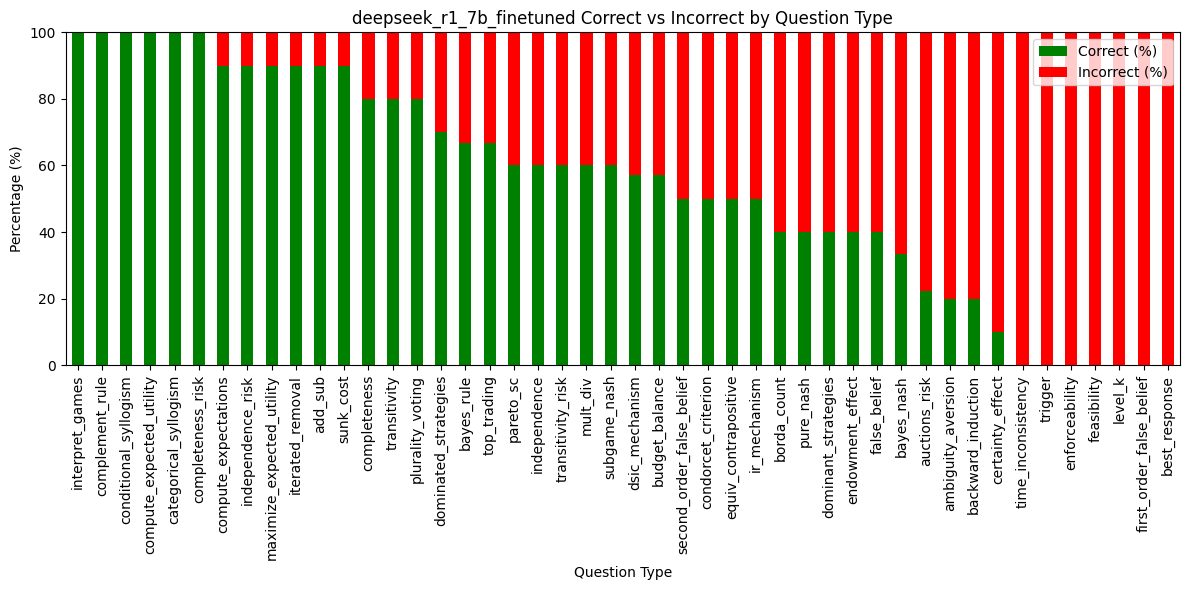

In [ ]:
plot_accuracy_by_question_type(deepseek_r1_7b_finetuned_df, "deepseek_r1_7b_finetuned")

In [ ]:
deepseek_r1_7b_selected_questions_df = process_all_files("/content/drive/MyDrive/CIS6200_Project/results_ds_7b_distilled_small")

Processing type: add_sub
9_0 has no matched option.
Processing type: ambiguity_aversion
Processing type: auctions_risk
5_0 has no matched option.
Processing type: backward_induction
Processing type: bayes_nash
Processing type: bayes_rule
Processing type: best_response
31_0 has no matched option.
Processing type: borda_count
24_0 has no matched option.
Processing type: budget_balance
2_0 has no matched option.
4_0 has no matched option.
Processing type: categorical_syllogism
8_0 has no matched option.
Processing type: certainty_effect
Processing type: complement_rule
Processing type: completeness
15992_0 has no matched option.
16007_0 has no matched option.
15986_0 has no matched option.
Processing type: completeness_risk
8017_0 has no matched option.
8011_0 has no matched option.
8003_0 has no matched option.
8016_0 has no matched option.
Processing type: compute_expectations
Processing type: compute_expected_utility
Processing type: conditional_syllogism
5_0 has no matched option.
8_0

In [ ]:
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'add_sub', 'correct'] += 1
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'auctions_risk', 'incorrect'] += 1
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'best_response', 'incorrect'] += 1
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'borda_count', 'correct'] += 1
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'budget_balance', 'correct'] += 2
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'categorical_syllogism', 'correct'] += 1
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'completeness', 'correct'] += 2
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'completeness', 'incorrect'] += 1
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'completeness_risk', 'correct'] += 4
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'conditional_syllogism', 'correct'] += 4
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'condorcet_criterion', 'correct'] += 1
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'condorcet_criterion', 'incorrect'] += 1
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'dominant_strategies', 'incorrect'] += 1
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'dominated_strategies', 'incorrect'] += 3
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'endowment_effect', 'incorrect'] += 2
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'endowment_effect', 'correct'] += 5
deepseek_r1_7b_selected_questions_df.loc[deepseek_r1_7b_selected_questions_df['question_type'] == 'false_belief', 'incorrect'] += 2





In [ ]:
print(deepseek_r1_7b_selected_questions_df)

                question_type  correct  incorrect  exceed_context
0                     add_sub        9          0               0
1          ambiguity_aversion        1          6               0
2               auctions_risk        6          3               0
3          backward_induction        4          6               0
4                  bayes_nash        2          2               0
5                  bayes_rule        5          1               0
6               best_response        3          3               0
7                 borda_count        5          3               0
8              budget_balance        3          2               0
9       categorical_syllogism        9          0               0
10           certainty_effect        5          4               0
11            complement_rule        8          0               0
12               completeness        6          1               0
13          completeness_risk        5          1               0
14       c

## **Gemma 2 9b**

In [ ]:
def extract_selected_option(response_text, options):
    """
    Extracts a single option number from the response_text.
    If the text explicitly mentions more than one option (e.g. "Option 1 and Option 2"),
    or matches multiple numeric candidates from the options block, returns None.
    """
    text = response_text.strip()

    # 1) look for explicit "Option <n>" mentions
    explicit = re.findall(r"Option\s+(\d+)", text, re.IGNORECASE)
    if len(explicit) > 1:
        # ambiguous: mentions multiple options
        return None
    if len(explicit) == 1:
        return int(explicit[0])

    # 2) fallback to numeric matching: collect *all* numbers in the text
    numbers = re.findall(r"(\d+(?:\.\d+)?)", text)
    if not numbers:
        return None

    matched_opts = set()
    for candidate in numbers:
        for line in options.split('\n'):
            if candidate in line:
                m = re.match(r"Option\s+(\d+):", line.strip())
                if m:
                    matched_opts.add(int(m.group(1)))

    # if exactly one unique option matched, return it; otherwise None
    if len(matched_opts) == 1:
        return matched_opts.pop()

    # either zero or multiple matches → ambiguous
    return None

def process_file(file_path, question_type):
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        print("Should not happen")
        return (question_type, 0, 0)

    correct = 0
    incorrect = 0

    for _, row in df.iterrows():
        selected_option = None

        # 1) If there's a non‐empty correct_response, use that…
        if 'correct_response' in df.columns \
           and pd.notna(row['correct_response']) \
           and str(row['correct_response']).strip():
            selected_text = str(row['correct_response']).strip()
        # 2) …otherwise, fall back to final_answer (if present)
        elif 'final_answer' in df.columns \
             and pd.notna(row['final_answer']) \
             and str(row['final_answer']).strip():
            selected_text = str(row['final_answer']).strip()
        else:
            selected_text = None

        selected_option = extract_selected_option(selected_text, str(row['options']))

        if selected_option is None:
            print(f"{row['question_id']} has no matched option.")

        expected_option = extract_expected_option(str(row['expected_answer']), str(row['options']))

        if expected_option is None:
            print(f"{row['question_id']} has no matched expected answer.")

        # Compare
        if selected_option is not None and expected_option is not None:
            if selected_option == expected_option:
                correct += 1
            else:
                incorrect += 1

    return (question_type, correct, incorrect)

In [ ]:
gemma_2_9b_df = process_all_files("/content/drive/MyDrive/CIS6200_Project/results_gemma_2_9b")

Processing type: add_sub
14_0 has no matched option.
16_0 has no matched option.
Processing type: ambiguity_aversion
2_0 has no matched option.
13_0 has no matched option.
Processing type: auctions_risk
37_0 has no matched option.
Processing type: backward_induction
51_0 has no matched option.
55_0 has no matched option.
60_0 has no matched option.
61_0 has no matched option.
67_0 has no matched option.
68_0 has no matched option.
69_0 has no matched option.
71_0 has no matched option.
77_0 has no matched option.
78_0 has no matched option.
79_0 has no matched option.
80_0 has no matched option.
81_0 has no matched option.
83_0 has no matched option.
84_0 has no matched option.
86_0 has no matched option.
87_0 has no matched option.
88_0 has no matched option.
91_0 has no matched option.
93_0 has no matched option.
95_0 has no matched option.
96_0 has no matched option.
Processing type: bayes_nash
9_0 has no matched option.
12_0 has no matched option.
14_0 has no matched option.
19_0 h

In [ ]:
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'add_sub', 'incorrect'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'ambiguity_aversion', 'incorrect'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'ambiguity_aversion', 'correct'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'auctions_risk', 'incorrect'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'backward_induction', 'incorrect'] += 20
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'backward_induction', 'correct'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'bayes_nash', 'correct'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'bayes_nash', 'incorrect'] += 12
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'bayes_rule', 'incorrect'] += 20
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'borda_count', 'incorrect'] += 4
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'budget_balance', 'correct'] += 12
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'budget_balance', 'incorrect'] += 10
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'categorical_syllogism', 'correct'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'categorical_syllogism', 'incorrect'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'certainty_effect', 'correct'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'certainty_effect', 'incorrect'] += 19
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'complement_rule', 'correct'] += 6
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'completeness', 'correct'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'compute_expectations', 'correct'] += 7
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'compute_expectations', 'incorrect'] += 4
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'compute_expected_utility', 'correct'] += 5
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'compute_expected_utility', 'incorrect'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'dominated_strategies', 'correct'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'dominated_strategies', 'incorrect'] += 4
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'dsic_mechanism', 'correct'] += 25
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'dsic_mechanism', 'incorrect'] += 7
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'endowment_effect', 'incorrect'] += 13
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'enforceability', 'correct'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'enforceability', 'incorrect'] += 24
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'equiv_contrapositive', 'correct'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'equiv_contrapositive', 'incorrect'] += 6
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'feasibility', 'incorrect'] += 27
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'gamblers_fallacy', 'correct'] += 7
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'independence', 'correct'] += 6
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'independence', 'incorrect'] += 9
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'independence_risk', 'correct'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'independence_risk', 'incorrect'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'interpret_games', 'correct'] += 3
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'interpret_games', 'incorrect'] += 5
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'ir_mechanism', 'correct'] += 12
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'ir_mechanism', 'incorrect'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'iterated_removal', 'incorrect'] += 7
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'level_k', 'incorrect'] += 13
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'maximize_expected_utility', 'incorrect'] += 4
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'pareto_sc', 'correct'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'pareto_sc', 'incorrect'] += 5
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'plurality_voting', 'incorrect'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'prob_basic', 'correct'] += 11
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'prob_basic', 'incorrect'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'pure_nash', 'incorrect'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'subgame_nash', 'incorrect'] += 18
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'sunk_cost', 'correct'] += 1
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'sunk_cost', 'incorrect'] += 2
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'time_inconsistency', 'incorrect'] += 9
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'trigger', 'incorrect'] += 39
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'transitivity_risk', 'correct'] += 4
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'transitivity', 'incorrect'] += 3
gemma_2_9b_df.loc[gemma_2_9b_df['question_type'] == 'top_trading', 'incorrect'] += 3

In [ ]:
print(gemma_2_9b_df)

                question_type  correct  incorrect
0                     add_sub       48          2
1          ambiguity_aversion        2         13
2               auctions_risk       15         35
3          backward_induction       11         39
4                  bayes_nash       16         34
5                  bayes_rule       14         36
6               best_response       10         40
7                 borda_count       27         23
8              budget_balance       25         25
9       categorical_syllogism       32         18
10           certainty_effect       21         29
11            complement_rule       50          0
12               completeness       46          4
13          completeness_risk       50          0
14       compute_expectations       44          6
15   compute_expected_utility       48          2
16      conditional_syllogism       40         10
17        condorcet_criterion       18         32
18        dominant_strategies       50          0


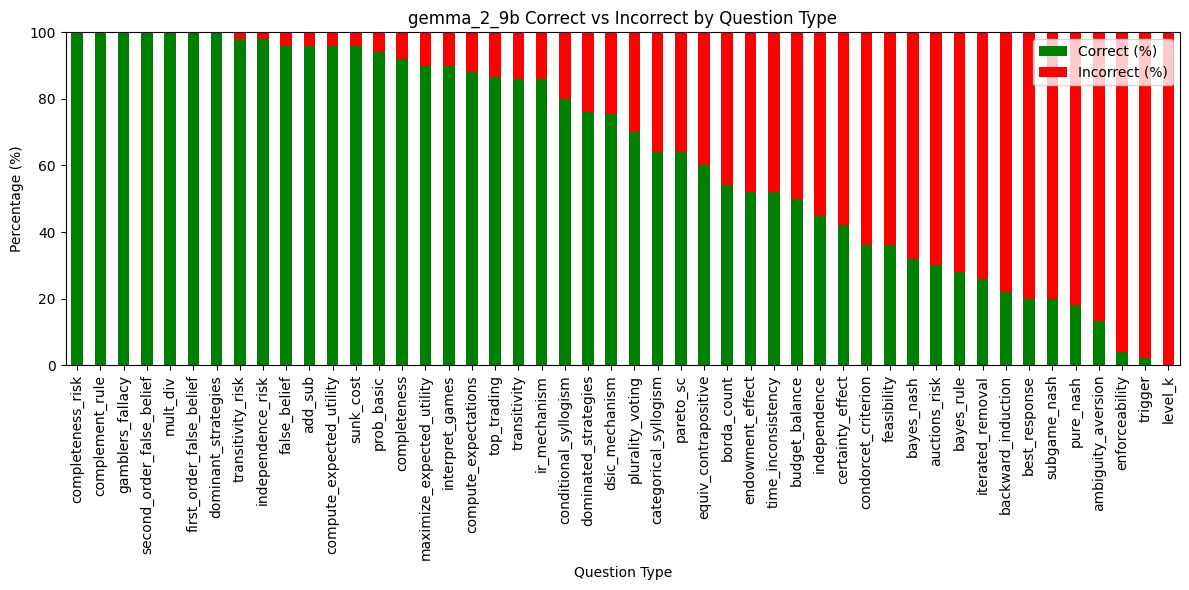

In [ ]:
plot_accuracy_by_question_type(gemma_2_9b_df, "gemma_2_9b")

## **Llama 3.1 8b**

In [ ]:
llama_8b_df = process_all_files("/content/drive/MyDrive/CIS6200_Project/results_llama_8b")

Processing type: completeness
Processing type: compute_expectations
Processing type: gamblers_fallacy
Processing type: first_order_false_belief
Processing type: bayes_nash
28_0  has no matched option.
Processing type: pure_nash
Processing type: independence
Processing type: level_k
Processing type: bayes_rule
10_0  has no matched option.
14_0  has no matched option.
34_0  has no matched option.
Processing type: categorical_syllogism
Processing type: independence_risk
Processing type: second_order_false_belief
Processing type: auctions_risk
Processing type: top_trading
Processing type: mult_div
31_0  has no matched option.
Processing type: prob_basic
3_0  has no matched option.
4_0  has no matched option.
6_0  has no matched option.
7_0  has no matched option.
8_0  has no matched option.
14_0  has no matched option.
19_0  has no matched option.
21_0  has no matched expected answer.
25_0  has no matched expected answer.
28_0  has no matched option.
29_0  has no matched expected answer.
3

In [ ]:
llama_8b_df.loc[llama_8b_df['question_type'] == 'bayes_nash', 'incorrect'] += 1
llama_8b_df.loc[llama_8b_df['question_type'] == 'bayes_rule', 'incorrect'] += 3
llama_8b_df.loc[llama_8b_df['question_type'] == 'mult_div', 'incorrect'] += 1
llama_8b_df.loc[llama_8b_df['question_type'] == 'prob_basic', 'incorrect'] += 11
llama_8b_df.loc[llama_8b_df['question_type'] == 'prob_basic', 'correct'] += 6
llama_8b_df.loc[llama_8b_df['question_type'] == 'add_sub', 'correct'] += 1
llama_8b_df.loc[llama_8b_df['question_type'] == 'false_belief', 'correct'] += 1
llama_8b_df.loc[llama_8b_df['question_type'] == 'feasibility', 'incorrect'] += 1
llama_8b_df.loc[llama_8b_df['question_type'] == 'transitivity', 'correct'] += 1
llama_8b_df.loc[llama_8b_df['question_type'] == 'dominated_strategies', 'incorrect'] += 7
llama_8b_df.loc[llama_8b_df['question_type'] == 'dominated_strategies', 'correct'] += 1
llama_8b_df.loc[llama_8b_df['question_type'] == 'endowment_effect', 'incorrect'] += 2
llama_8b_df.loc[llama_8b_df['question_type'] == 'trigger', 'incorrect'] += 3
llama_8b_df.loc[llama_8b_df['question_type'] == 'iterated_removal', 'incorrect'] += 3
llama_8b_df.loc[llama_8b_df['question_type'] == 'best_response', 'incorrect'] += 3
llama_8b_df.loc[llama_8b_df['question_type'] == 'subgame_nash', 'correct'] += 1


### some questions are problematic
### some reponse of llama are too long and model is clearly confused, iterated_removal qid 44



In [ ]:
print(llama_8b_df)

                question_type  correct  incorrect
0                completeness       48          2
1        compute_expectations        5         45
2            gamblers_fallacy       50          0
3    first_order_false_belief       34         16
4                  bayes_nash       12         38
5                   pure_nash        0         50
6                independence       20         10
7                     level_k        1         49
8                  bayes_rule        8         42
9       categorical_syllogism       32         18
10          independence_risk       38         12
11  second_order_false_belief       38         12
12              auctions_risk        3         47
13                top_trading       42          8
14                   mult_div       43          7
15                 prob_basic       22         28
16                    add_sub       40         10
17               false_belief       41          9
18                feasibility       29         21


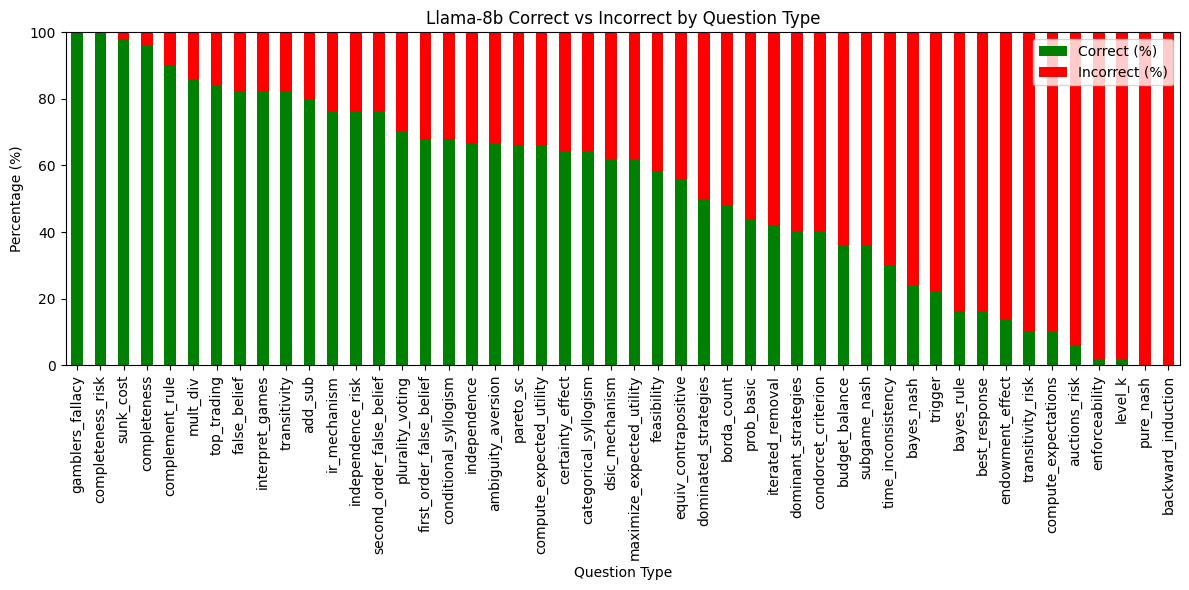

In [ ]:
plot_accuracy_by_question_type(llama_8b_df, "Llama-8b")

## **Analyze Data Categories**

In [ ]:
DATA_PATH = "/content/drive/MyDrive/CIS6200_Project/all_qa_df.pkl"